**2a.**
Read the grayscale image brain-noisy.png and the brain mask mask.png, which are provided
along with this sheet on eCampus. Reduce the salt and pepper noise in the image using a median
filter. (1P)
Hint: You do not have to implement the median filter yourself, you may use a suitable Python
package.

**2b.**
Plot a log-scaled histogram of the pixels within the brain mask. It should show how frequently
different intensity values occur in the image. Based on this histogram, what are approximate
intensity ranges for cerebrospinal fluid, gray matter, or white matter? What are their approximate
mixing weights? (2P)

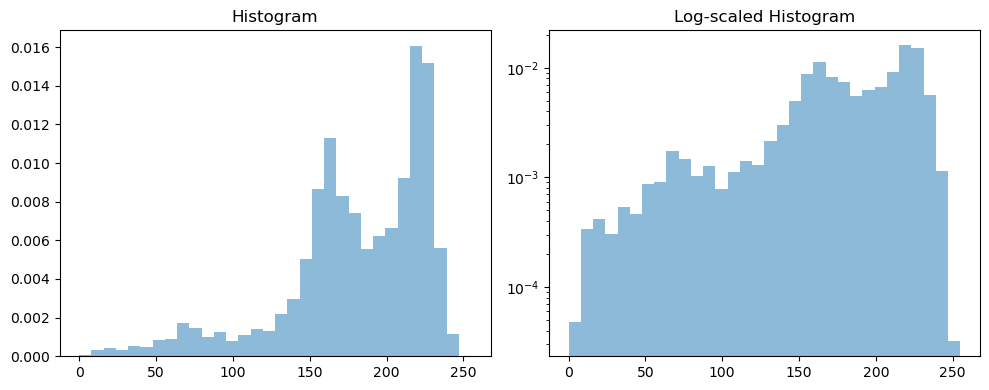


                            Peak (**)   Intensity range     Mixing weight (*)
CSF (cerebrospinal fluid):  75          20 - 100            0.14
Gray matter:                160         100 - 175           0.37
White matter:               225         175 - 255           0.49

* Mixing weights are estimated by 'peak x intensity range' and afterwards normalized.
** Peaks are extracted from the non-log histogram.



In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

mask_file = 'mask.png'
img_file = 'brain-noisy.png'

mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)

# kernel size of 5 produced the best result
img_filt = cv2.medianBlur(img, ksize=5)

mask = (mask>0).astype(np.uint8)

hist_range = [0,255]
hist_bins = 32
hist_pixels = img_filt[mask > 0].astype(np.float32)

# cv2.imshow('Filtering Step', cv2.hconcat([img, img_filt, img_hist]))
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Plotting histograms
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(
    x=hist_pixels,
    bins = hist_bins,
    range=hist_range,
    density=True,
    alpha=0.5,
    log=False
)
axes[0].set_title("Histogram")
axes[1].hist(
    x=hist_pixels,
    bins = hist_bins,
    range=hist_range,
    density=True,
    alpha=0.5,
    log=True
)
axes[1].set_title("Log-scaled Histogram")

plt.tight_layout()
plt.show()


output = f"""
                            Peak (**)   Intensity range     Mixing weight (*)
CSF (cerebrospinal fluid):  75          20 - 100            0.14
Gray matter:                160         100 - 175           0.37
White matter:               225         175 - 255           0.49

* Mixing weights are estimated by 'peak x intensity range' and afterwards normalized.
** Peaks are extracted from the non-log histogram.
"""
print(output)


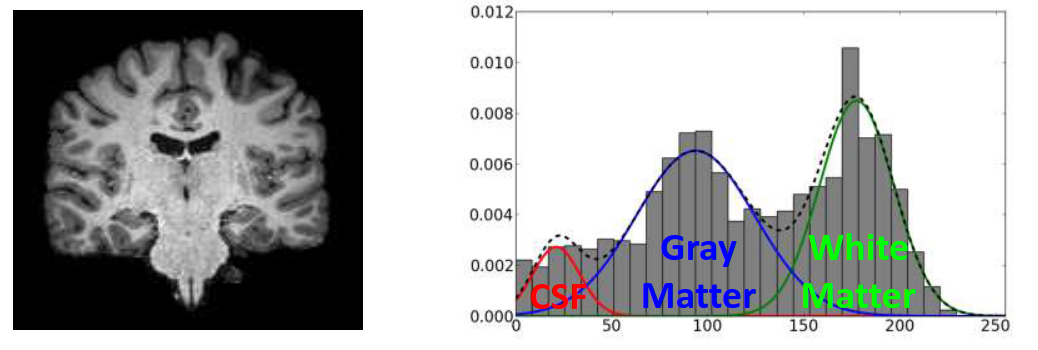

**2c.** Now, we will use a three-compartment Gaussian Mixture Model (GMM) for image segmentation:
Based on the histogram from b), find a plausible initialization of the GMM parameters. Use them
to compute the responsibilities ρik of cluster k for pixel i. (2P)

**2d.** Visualize the responsibilities by mapping the probabilities of belonging to the CSF, gray matter,
and white matter clusters to the red, blue, and green color channels, respectively. Please submit
the resulting image. (1P)

In [33]:
# Using the GMM from the sklearn package that provides EM parameter optimization.
# In the first step, we only want to run one iteration to compute the density function 
# based on our initial parameters, that we estimated by visual inspection from the 
# plotted histogram.


# GMM settings
gmm_k = 3
gmm_init_weights = [0.14, 0.37, 0.49]
gmm_init_means = np.array([75, 160, 225]).reshape(-1,1)
gmm_init_vars = np.array([400, 360, 400], dtype=np.float32)
gmm_init_prec      = 1.0 / gmm_init_vars

gmm_X = img_filt[mask > 0].astype(np.float32)
gmm_X = gmm_X.reshape(-1, 1)
gmm_max_iters = 1      # only running one iteration!

# GMM init
gmm1 = GaussianMixture(
    n_components=gmm_k, 
    covariance_type = 'spherical',
    max_iter=gmm_max_iters,
    weights_init=gmm_init_weights,
    precisions_init=gmm_init_prec,
    means_init=gmm_init_means
)

# GMM running
gmm1.fit(gmm_X)

# Visualize the clutering result after one iteration 
img_cluster_after_one_iter = np.zeros(shape=np.hstack([img_filt.shape,3]), dtype=np.uint8)
for y in np.arange(img_filt.shape[0]):
    for x in np.arange(img_filt.shape[1]):
        if mask[y,x] > 0:
            input_X = img_filt[y,x].reshape(-1, 1).astype(np.float32)
            prob = gmm1.predict_proba(input_X)[0]
            prob2 = np.array([prob[1], prob[2], prob[0]])
            img_cluster_after_one_iter[y,x] = (255*prob2).astype(np.uint8)

cv2.imshow('Clustering after 1 Step', img_cluster_after_one_iter)
cv2.waitKey(0)
cv2.destroyAllWindows()      
cv2.imwrite('task2_cluster_res_after_one_iter.png', img_cluster_after_one_iter)

/home/lukas/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


True

**2e.** Use the update rules provided in the lecture to re-compute the parameters μk, σk, and πk. (1P)

**2f.** Iterate the E and M steps of the algorithm until convergence. Please submit the final parameter
values, a visualization of the final responsibilities, and your code. Remember to constrain your
algorithm to the brain mask. (2P)

Means:   [ 81.6414024  167.91917464 220.12252571]
Sigmas:  [33.65568386 18.57245804 10.72828204]
Weights: [0.11289601 0.45831706 0.42878694]


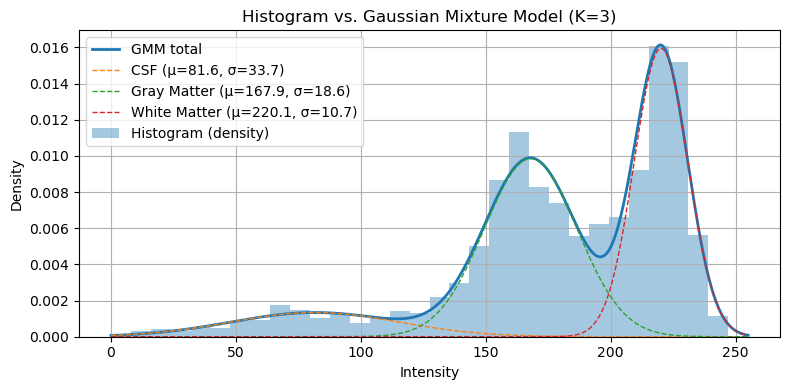

In [34]:
# Using the GMM from the sklearn package that provides EM parameter optimization.
# In the second step we want to alternate between the steps of EM-algorithm for multiple 
# iterations. Goal is to optimize the parameters until the EM-algorithm converges. 
# The optimized GMM and its components are plotted and the resulting clustering output is
# exported.  

# GMM settings (we want to use the same intial params)
gmm_k = 3
gmm_init_weights = [0.14, 0.37, 0.49]
gmm_init_means = np.array([75, 160, 225]).reshape(-1,1)
gmm_init_vars = np.array([400, 360, 400], dtype=np.float32)
gmm_init_prec      = 1.0 / gmm_init_vars

gmm_X = img_filt[mask > 0].astype(np.float32)
gmm_X = gmm_X.reshape(-1, 1)
gmm_max_iters = 1000      # this time for multiple iterations e.g. 1000

# GMM init
gmm = GaussianMixture(
    n_components=gmm_k, 
    covariance_type = 'spherical',
    max_iter=gmm_max_iters,
    weights_init=gmm_init_weights,
    precisions_init=gmm_init_prec,
    means_init=gmm_init_means
)

# GMM running
gmm.fit(gmm_X)

# Visualize the clutering result 
img_cluster_converged = np.zeros(shape=np.hstack([img_filt.shape,3]), dtype=np.uint8)
for y in np.arange(img_filt.shape[0]):
    for x in np.arange(img_filt.shape[1]):
        if mask[y,x] > 0:
            input_X = img_filt[y,x].reshape(-1, 1).astype(np.float32)
            prob = gmm.predict_proba(input_X)[0]
            prob2 = np.array([prob[1], prob[2], prob[0]])
            img_cluster_converged[y,x] = (255*prob2).astype(np.uint8)

cv2.imshow('Clustering after convergence', img_cluster_converged)
cv2.waitKey(0)
cv2.destroyAllWindows()      
cv2.imwrite('task2_cluster_res_converged.png', img_cluster_converged)

# Results
if gmm.converged_:
    means  = gmm.means_.ravel()            
    vars_  = gmm.covariances_              
    sigmas = np.sqrt(vars_)                
    weights = gmm.weights_                 
    print("Means:  ", means)
    print("Sigmas: ", sigmas)
    print("Weights:", weights)
    
    # Plotting
    pixels = gmm_X.ravel()
    counts, bin_edges = np.histogram(
        pixels,
        bins=32,
        range=(0, 255),
        density=True
    )
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # feine x-Achse für glatte PDF
    x = np.linspace(0, 255, 500)


    def gaussian(x, mu, sigma):
        return (1.0 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    component_pdfs = []
    for w, m, s in zip(weights, means, sigmas):
        component_pdfs.append(w * gaussian(x, m, s))

    gmm_pdf = np.sum(component_pdfs, axis=0)

    plt.figure(figsize=(8,4))

    # Histogramm
    plt.bar(bin_centers, counts,
            width=(bin_edges[1] - bin_edges[0]),
            alpha=0.4, align="center", label="Histogram (density)")

    # GMM
    plt.plot(x, gmm_pdf, linewidth=2, label="GMM total")
    
    # Gaussians components
    labels = ['CSF', 'Gray Matter', 'White Matter']
    for k, comp in enumerate(component_pdfs):
        plt.plot(x, comp, linestyle="--", linewidth=1,
                label=f"{labels[k]} (μ={means[k]:.1f}, σ={sigmas[k]:.1f})")

    plt.xlabel("Intensity")
    plt.ylabel("Density")
    plt.title("Histogram vs. Gaussian Mixture Model (K=3)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
else:
    print('GMM not converged.')
            